In [ ]:
# Training CNN with 3D MNIST dataset

In [1]:
import os
# turning off annoying tensorflow verbose logging messages
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv3D, MaxPooling3D
from tensorflow.keras.utils import to_categorical

import h5py

from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

## Loading the cannonical MNIST dataset to use as seed.

Loaging 3D MNIST from the H5 file:

In [2]:
dataset_file = h5py.File('3d-mnist-luiz.h5', 'r')

train_x = dataset_file["train_X"][:]
test_x = dataset_file["test_X"][:] 

train_y = to_categorical(dataset_file["train_y"][:])
test_y = to_categorical(dataset_file["test_y"][:])

## Plotting a 3D digit

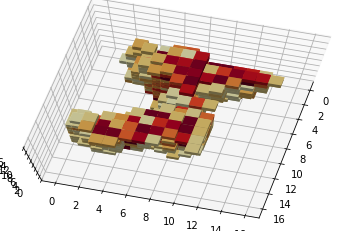

In [7]:
def print_grid(grid):

    grid_shape = grid.shape

    flattened = grid.reshape(((grid_shape[0] * grid_shape[1] * grid_shape[2]), 3))
    voxel_grid_array = np.zeros(len(flattened))

    for i in range(len(flattened)):
        temp = flattened[i]
        if temp[0] > 0 or temp[1] > 0 or temp[2] > 0:
            voxel_grid_array[i] = 1

    voxel_grid = voxel_grid_array.reshape((grid_shape[0], grid_shape[1], grid_shape[2]))

    fig = pyplot.figure()
    ax = fig.add_subplot(projection='3d')
    ax.azim = 15
    ax.dist = 8
    ax.elev = 75
    ax.voxels(voxel_grid, facecolors=grid)

    pyplot.show()

sample = train_X[0]

print_grid(sample)

## Training

In [8]:
def define_model():
	model = Sequential()
	model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample.shape))
	model.add(MaxPooling3D(pool_size=(2, 2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	return model

## running the train

In [9]:

model = define_model()

model.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
                metrics=['accuracy'])

history = model.fit(train_x, train_y, batch_size=32, epochs=4, verbose=1, validation_split=0.2)

Epoch 1/4
1500/1500 [==============================] - 668s 351ms/step - loss: 0.3047 - accuracy: 0.9024 - val_loss: 0.1474 - val_accuracy: 0.9540
Epoch 2/4
1500/1500 [==============================] - 525s 350ms/step - loss: 0.1249 - accuracy: 0.9601 - val_loss: 0.1254 - val_accuracy: 0.9590
Epoch 3/4
1500/1500 [==============================] - 548s 366ms/step - loss: 0.0776 - accuracy: 0.9744 - val_loss: 0.1256 - val_accuracy: 0.9615
Epoch 4/4
1500/1500 [==============================] - 510s 340ms/step - loss: 0.0486 - accuracy: 0.9846 - val_loss: 0.1192 - val_accuracy: 0.9649


## Checking model

First, let's plot the training statistics.

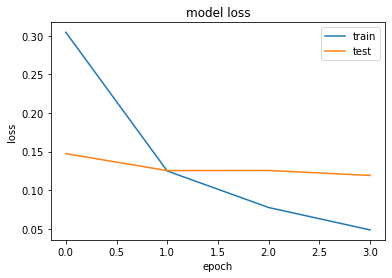

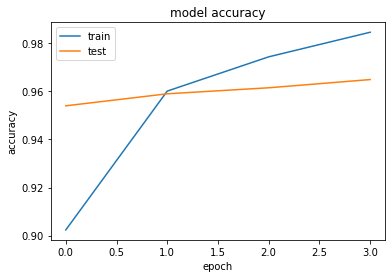

In [15]:
import pandas as pd

def plot_history(history):

  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.title('model loss')
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'test'], loc='upper right')
  pyplot.show()

  pyplot.plot(history.history['accuracy'])
  pyplot.plot(history.history['val_accuracy'])
  pyplot.title('model accuracy')
  pyplot.ylabel('accuracy')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'test'], loc='upper left')
  pyplot.show()

plot_history(history)


Now, let's evaluate the performance on the test data.

In [10]:
score = model.evaluate(test_x, test_y, verbose=0)
print('Test accuracy: %.2f%% Test loss: %.3f' % (score[1]*100, score[0]))


Test accuracy: 96.55% Test loss: 0.119
